In [301]:
%pip install ipykernel numpy pandas matplotlib seaborn scikit-learn xgboost

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Підготовчий етап
**Датасет:** California Housing Prices [https://www.kaggle.com/datasets/camnugent/california-housing-prices](https://www.kaggle.com/datasets/camnugent/california-housing-prices)

1. Провести аналіз вибраного набору даних,
1. визначити вхідні та вихідні параметри,
1. візуалізувати залежності входів та виходу,
1. детектувати аномалії, неповні зразки у даних, тощо,
1. провести кореляційний аналіз входів та виходів набору даних, виявити взаємозалежні фактори.
1. Провести підготовку даних до подальшого використання.
1. Обраний та відфільтрований набір даних розбити на навчальну та тестову частину (70% на навчання, 30% на тест).

In [302]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# import sklearn as skl
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import OneHotEncoder

import time
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb

In [303]:
data_start = pd.read_csv("Data/housing.csv")
print(data_start.shape)
data_start.head()

(20640, 10)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


ocean_proximity виглядає важливою, по ідеї чим ближче до моря, тим дорожче, тому перетворимо її, на більш зрозумілу річ для регресії

In [304]:
# texts = data_start.ocean_proximity.unique()
# hot_encoder, hot_decoder = {item: i for i, item in enumerate(texts)}, {i: item for i, item in enumerate(texts)}
# def hot_coder(x, hot_dict: dict):
#     return hot_dict[x]
# # data_start.ocean_proximity = data_start.ocean_proximity.apply(hot_coder, args=(hot_encoder, ))

In [305]:
data = pd.get_dummies(data_start, columns=['ocean_proximity'], drop_first=False)
data = data.rename(columns={
    "ocean_proximity_<1H OCEAN": "1h_ocean",
    "ocean_proximity_INLAND": "inland",
    "ocean_proximity_ISLAND": "island",
    "ocean_proximity_NEAR BAY": "near_bay",
    "ocean_proximity_NEAR OCEAN": "near_ocean",
})
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,1h_ocean,inland,island,near_bay,near_ocean
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,False,False,False,True,False
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,False,False,False,True,False
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,False,False,False,True,False
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,False,False,False,True,False
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,False,False,False,True,False


## Провести аналіз вибраного набору даних,

In [306]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


Кількість total_bedrooms менше ніж в інших, є НаН

Дуже дивне значення коштування дому 500001.00

In [307]:
data.total_bedrooms.value_counts(dropna=False)

total_bedrooms
NaN       207
280.0      55
331.0      51
345.0      50
343.0      49
         ... 
2009.0      1
2249.0      1
3114.0      1
1625.0      1
1742.0      1
Name: count, Length: 1924, dtype: int64

In [308]:
data[data.total_bedrooms.isna()]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,1h_ocean,inland,island,near_bay,near_ocean
290,-122.16,37.77,47.0,1256.0,NaN,570.0,218.0,4.3750,161900.0,False,False,False,True,False
341,-122.17,37.75,38.0,992.0,NaN,732.0,259.0,1.6196,85100.0,False,False,False,True,False
538,-122.28,37.78,29.0,5154.0,NaN,3741.0,1273.0,2.5762,173400.0,False,False,False,True,False
563,-122.24,37.75,45.0,891.0,NaN,384.0,146.0,4.9489,247100.0,False,False,False,True,False
696,-122.10,37.69,41.0,746.0,NaN,387.0,161.0,3.9063,178400.0,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20267,-119.19,34.20,18.0,3620.0,NaN,3171.0,779.0,3.3409,220500.0,False,False,False,False,True
20268,-119.18,34.19,19.0,2393.0,NaN,1938.0,762.0,1.6953,167400.0,False,False,False,False,True
20372,-118.88,34.17,15.0,4260.0,NaN,1701.0,669.0,5.1033,410700.0,True,False,False,False,False
20460,-118.75,34.29,17.0,5512.0,NaN,2734.0,814.0,6.6073,258100.0,True,False,False,False,False


Дамо total_bedrooms її медіанні значення

In [309]:
data['total_bedrooms'] = data['total_bedrooms'].fillna(data['total_bedrooms'].median())
data[data.total_bedrooms.isna()].head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,1h_ocean,inland,island,near_bay,near_ocean


In [310]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20640.0,536.838857,419.391878,1.0000,297.0000,435.0000,643.25000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


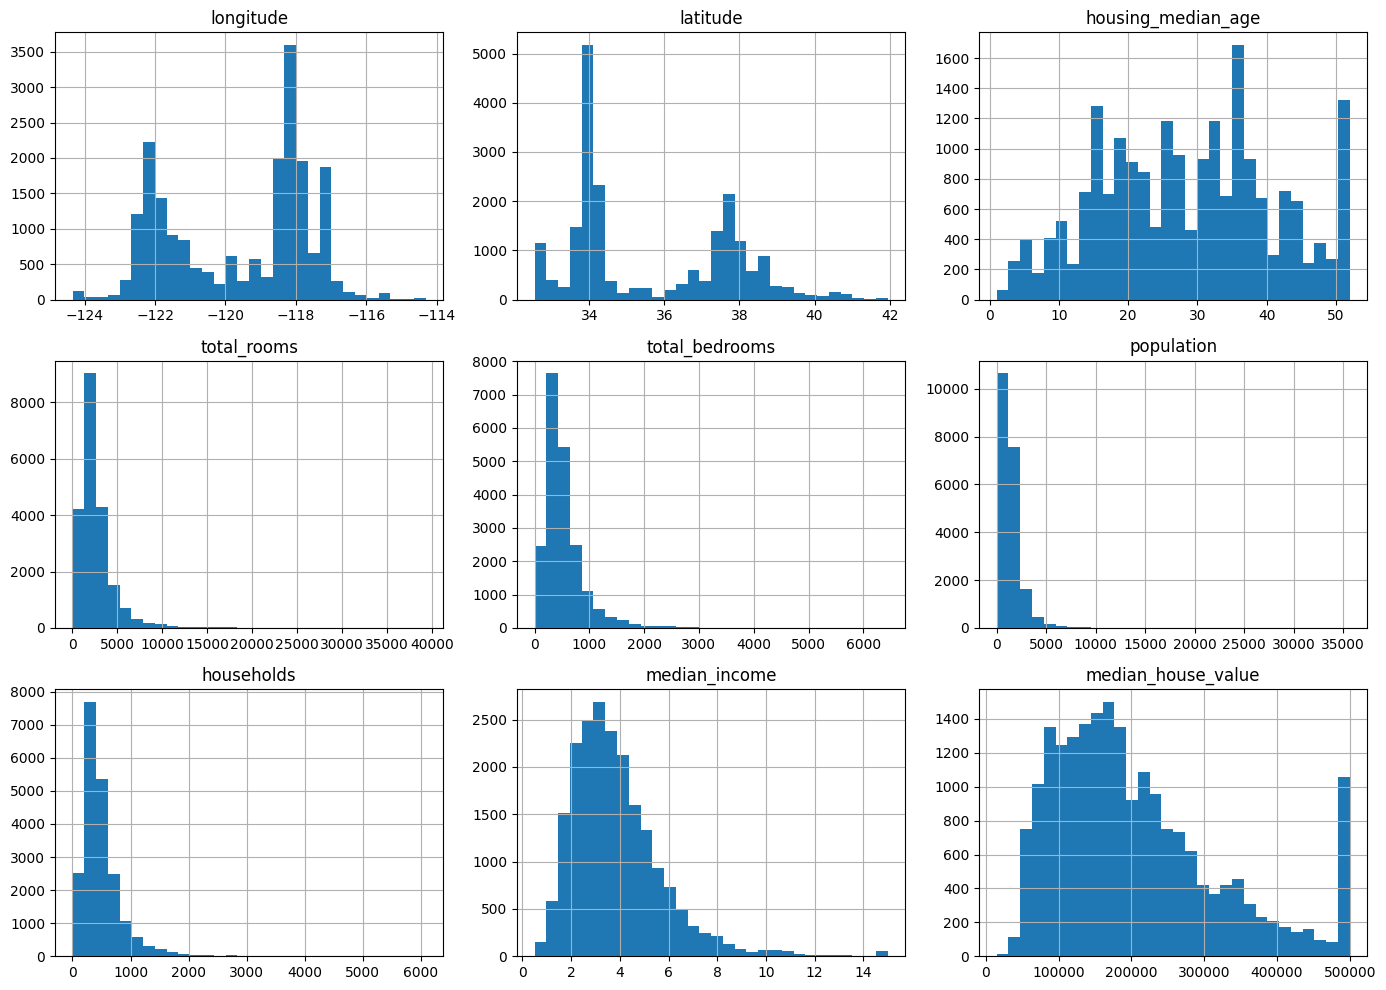

In [311]:
data.hist(bins=30, figsize=(14,10))
plt.tight_layout()
plt.show()


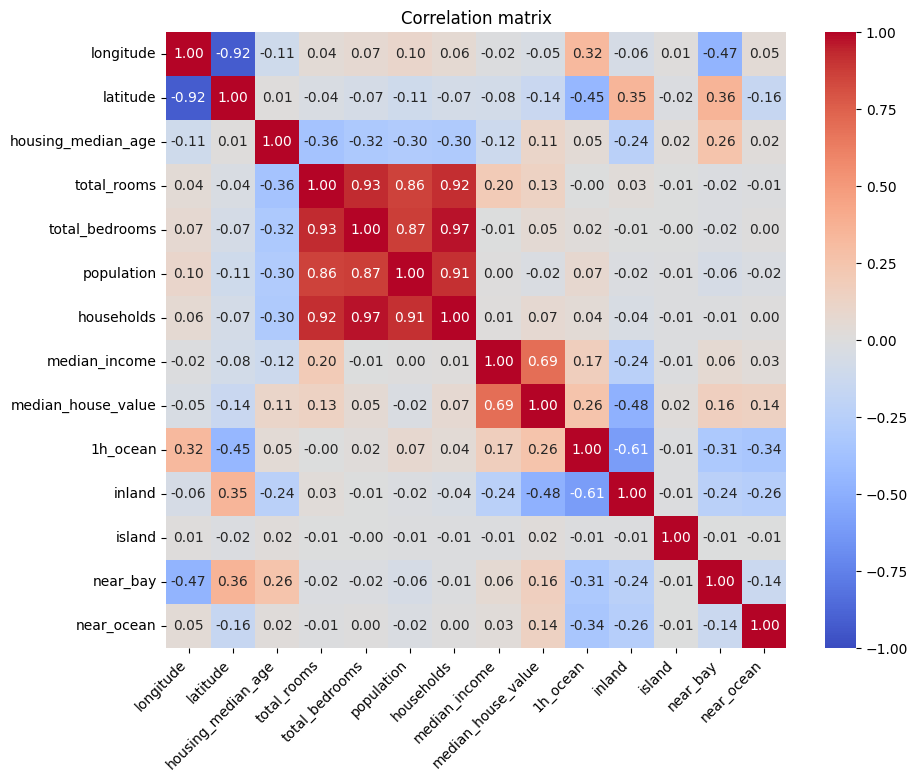

In [312]:
corr = data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.xticks(rotation=45, ha='right')
plt.title('Correlation matrix')
plt.show()


Вхідними параметрами будуть: housing_median_age, average_rooms_per_household (total_rooms/households), average_bedrooms_per_room (total_bedrooms/households / average_rooms_per_household), average_population_per_household (population/households), households, median_income, 1h_ocean, inland, island, near_bay, near_ocean

Вихідним параметром буде: median_house_value

In [313]:
data['average_rooms_per_household'] = data['total_rooms'] / data['households']
data['average_bedrooms_per_room'] = (data['total_bedrooms'] / data['households']) / (data['average_rooms_per_household'])   # + 1e-6
data['average_population_per_household'] = data['population'] / data['households']

data['log_median_house_value'] = np.log1p(data['median_house_value'])

data[['average_rooms_per_household','average_bedrooms_per_room','average_population_per_household', 'log_median_house_value']].head()

,average_rooms_per_household,average_bedrooms_per_room,average_population_per_household,log_median_house_value
0,6.984127,0.146591,2.555556,13.022766
1,6.238137,0.155797,2.109842,12.789687
2,8.288136,0.129516,2.802260,12.771673
3,5.817352,0.184458,2.547945,12.740520
4,6.281853,0.172096,2.181467,12.743154


In [314]:
features = data.columns.drop(['total_rooms', 'total_bedrooms', 'population', 'median_house_value', 'log_median_house_value'])  # 'latitude', 'longitude', 
X = data[features].copy()
y = data['median_house_value'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# X_train_scaled = X_train.astype(float)
# X_test_scaled = X_test.astype(float)
X_train_scaled.shape, X_test_scaled.shape

((14448, 13), (6192, 13))

# Реалізація моделі

1. SciKit learn
1. XGBoost
1. Vanilla Python (Numpy/Pandas)

## SciKit learn

In [315]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

y_pred_lr = lr_model.predict(X_test_scaled)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print(f"[Scikit-Learn Linear Regression] RMSE: {rmse_lr:.2f}")
print(f"[Scikit-Learn Linear Regression] R2: {r2_lr:.4f}")

[Scikit-Learn Linear Regression] RMSE: 73229.11
[Scikit-Learn Linear Regression] R2: 0.5914


## XGBoost

In [316]:
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_test_scaled)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"[XGBoost] RMSE: {rmse_xgb:.2f}")
print(f"[XGBoost] R2: {r2_xgb:.4f}")

[XGBoost] RMSE: 47164.92
[XGBoost] R2: 0.8305


## Vanilla Python (Numpy/Pandas)

In [317]:
X_train_vanilla = np.concat((np.ones((X_train_scaled.shape[0], 1)), X_train_scaled.values), axis=1, dtype=float)
X_test_vanilla = np.concat((np.ones((X_test_scaled.shape[0], 1)), X_test_scaled.values), axis=1, dtype=float)
y_train_vanilla = y_train.values

XT_X = X_train_vanilla.T @ X_train_vanilla

XT_X_inv = np.linalg.inv(XT_X)

XT_y = X_train_vanilla.T  @ y_train_vanilla

theta = XT_X_inv @ XT_y

y_pred_vanilla = X_test_vanilla @ theta

mse_vanilla = np.mean((y_test - y_pred_vanilla) ** 2)
rmse_vanilla = np.sqrt(mse_vanilla)
ss_res = np.sum((y_test - y_pred_vanilla) ** 2)
ss_tot = np.sum((y_test - np.mean(y_test)) ** 2)
r2_vanilla = 1 - (ss_res / ss_tot)

print(f"[Vanilla Python (Normal Eq)] RMSE: {rmse_vanilla:.2f}")
print(f"[Vanilla Python (Normal Eq)] R2: {r2_vanilla:.4f}")

[Vanilla Python (Normal Eq)] RMSE: 73222.63
[Vanilla Python (Normal Eq)] R2: 0.5915


# Аналіз результатів

1. Вибір оптимальних параметрів регресій, їх обгрунтування
2. Оцінка помилок на начальній та тестовій вибірках
3. Порівняння результатів різних підходів (співпали чи ні, причини чому могли не співпасти, runtime тощо)
4. Порівняти результати з аналогічними результатами, які отримані в результаті використання вбудованих функцій
5. Результати оформити протоколом

               Model          RMSE  R2 Score
0    Scikit-Learn LR  73229.105828  0.591441
1            XGBoost  47164.920908  0.830517
2  Vanilla Python LR  73222.631381  0.591513


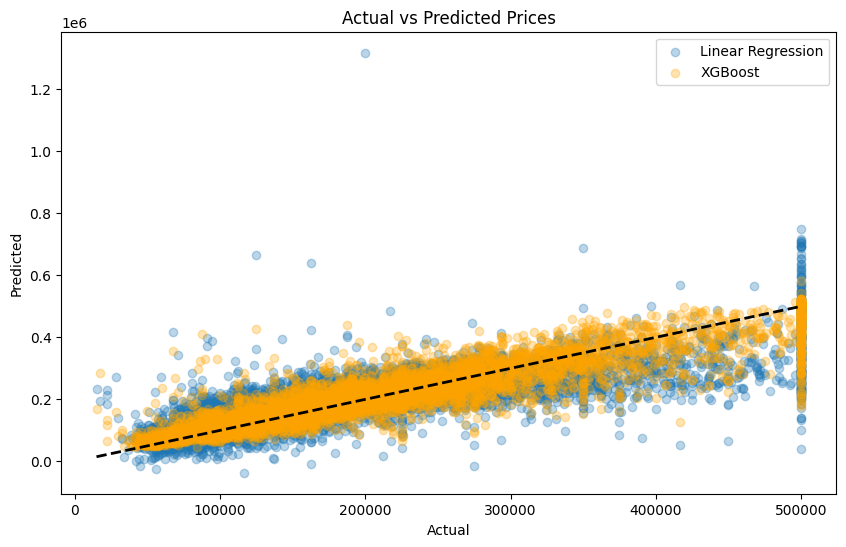

In [ ]:
results = pd.DataFrame({
    'Model': ['Scikit-Learn LR', 'XGBoost', 'Vanilla Python LR'],
    'RMSE': [rmse_lr, rmse_xgb, rmse_vanilla],
    'R2 Score': [r2_lr, r2_xgb, r2_vanilla]
})

print(results)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lr, alpha=0.3, label='Linear Regression')
plt.scatter(y_test, y_pred_xgb, alpha=0.3, color='orange', label='XGBoost')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.show()

# Контрольні питання

1. **Що таке ансамблювання та для чого воно використовується?**
Ансамблювання — поєднання кількох моделей для отримання кращої узагальнюючої здатності. Зазвичай знижує дисперсію (bagging), зміщення (boosting) або отримує кращу стабільність (stacking, voting).

2. **Які моделі базуються на принципі лінійної регресії?**
OLS (ordinary least squares), Ridge, Lasso, ElasticNet, Logistic Regression (для класифікації — перетворення цілі), Bayesian Linear Regression, Elastic Net тощо.

3. **Що таке XGBoost?**
XGBoost — ефективна імплементація градієнтного бустингу дерев рішень з оптимізаціями по швидкості та пам'яті, регуляризацією, обробкою відсутніх значень і ранньою зупинкою.
